In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"

# functions for PSTH
from scipy.signal import gaussian
from scipy.ndimage import filters
def rate_binning(spike_times,time_bins,binsize):
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>=t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return average

def smoothing(signal,sd,binsize):
    ''' aplly gaussian filter per trial'''
    kernel = gaussian(signal.shape[-1],sd/binsize)
    ga = np.zeros(signal.shape)
    if len(signal.shape)>3:
        for dim1 in range(signal.shape[0]):
            for dim2 in range(signal.shape[1]):
                for dim3 in range(signal.shape[2]):
                    ga[dim1,dim2,dim3,:] = filters.convolve1d(signal[dim1,dim2,dim3,:], kernel/kernel.sum())
    else:
        for dim1 in range(signal.shape[0]):
            for dim2 in range(signal.shape[1]):
                ga[dim1,dim2,:] = filters.convolve1d(signal[dim1,dim2,:], kernel/kernel.sum())
                
    return ga

Load preprocessed data and extract sequence variables

In [4]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe.pkl'%(animal_id)))

In [5]:
# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

['PFC_MU', 'PPC_MU', 'PFC_SU', 'PPC_SU', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']


In [6]:
soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    
Session = np.concatenate([np.ones(len(Local[i]))*i for i in range(len(Local))])
Local = np.concatenate(Local)
Global = np.concatenate(Global)
Blocktype = np.concatenate(Blocktype)
Block = np.concatenate(Block)
Include = np.concatenate(Include)
StimID = np.concatenate(StimID)

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


PSTH

In [12]:
# load PSTH
MUA = []
MUA_smooth = []
sess = 0
nsess = ndates
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_%s.npy'%date))
        
        ntr,nch,nbins = Rb.shape
        
        MUA.append(Rb)
        
        # smooth PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_%s.npy'%date))
        MUA_smooth.append(Rb)
        
        sess += 1
        
del Rb#,Rc
MUA = np.concatenate(MUA)
MUA_smooth = np.concatenate(MUA_smooth)

# time vector
time_bins = np.load(os.path.join(out_path,'time_bins_seq_%s.npy'%dates[0])) # time vector
time_bins_gauss = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector
binsize = np.round(np.mean(np.diff(time_bins)),3)
time_bins = time_bins + binsize
time_bins_gauss = time_bins_gauss + binsize

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


Compute d'

In [ ]:
def d_prime(x,y):
    ''' calculate d' value for two variables '''
    numerator = np.sqrt(2) * abs(np.mean(x) - np.mean(y))
    denominator = np.sqrt(np.var(x) + np.var(y))
    d = numerator / denominator
    return d

- responsiveness

In [14]:
# get d' for each channel per session and use t-test to get p-value
from scipy.stats import ttest_ind, ttest_rel, ranksums
from statsmodels.stats.multitest import multipletests

alpha = 0.05 # significance thrreshold

soa = 0.6 # soa of data
#### TIME WINDOWS ####
window_fix = np.arange(0, np.argmin(abs(time_bins)))
window_seq = np.arange( int((abs(time_bins[0])+3*soa)/binsize), int((abs(time_bins[0])*2 + 3*soa)/binsize)) # define averaging window to average firing rate

nsess = len(dates); nch = MUA.shape[1]
Dprime_seq = np.zeros((nsess,nch))
T_seq = np.zeros((nsess,nch))
P_seq = np.zeros((nsess,nch))
for sess in range(nsess):
    ind = Session==sess
    for ch in range(nch):
        fix_resp =  np.mean(MUA[ind,ch,:][:,window_fix],-1) # average response to stimulus A
        seq_resp =  np.mean(MUA[ind,ch,:][:,window_seq],-1) # average response to stimulus A
        Dprime_seq[sess,ch] = d_prime(fix_resp,seq_resp)
        T_seq[sess,ch], P_seq[sess,ch] = ttest_rel(fix_resp,seq_resp)

# run false discovery rate procedure on p values from all sessions and channels together
p_flat = P_seq.flatten()
fdr = multipletests(p_flat, alpha=alpha)
p_corr = fdr[1]
P_seq = np.reshape(p_corr,(nsess,nch)) # put back into original matrix



- local and global effect


In [15]:
# get d' for each channel per session and use t-test to get p-value

# define averaging window to average firing rate: from 50 ms after last stim on to 1 sec
window_loc = np.arange( int((abs(time_bins[0])+ 3*soa + 0.05)/binsize), int((abs(time_bins[0]) + 3*soa + 1)/binsize)) 
window_glob = np.arange( int((abs(time_bins[0])+ 3*soa + 0.4)/binsize), int((abs(time_bins[0]) + 3*soa + 1)/binsize)) 


Dprime_loc = np.zeros((nsess,nch))*np.nan
Dprime_glob = np.zeros((nsess,nch))*np.nan
U_loc = np.zeros((nsess,nch))*np.nan
P_loc = np.zeros((nsess,nch))*np.nan
U_glob = np.zeros((nsess,nch))*np.nan
P_glob = np.zeros((nsess,nch))*np.nan
for sess in range(nsess):
    # variable defining response sites
    responsive_sites = np.where(P_seq[sess,:]<=alpha)[0]
    
    # LOCAL deviant, only global standards
    ind_dev = (Session==sess) & (Local==1) & (Global==0) & (Include==1)# trials with local deviant
    ind_stand = (Session==sess) & (Local==0) & (Global==0) & (Include==1)# trials with local standard
    for ch in responsive_sites:
        dev_resp =  np.mean(MUA[ind_dev,ch,:][:,window_loc],-1) # average response to local deviant
        stand_resp =  np.mean(MUA[ind_stand,ch,:][:,window_loc],-1) # average response to local standard
        Dprime_loc[sess,ch] = d_prime(dev_resp,stand_resp)
        U_loc[sess,ch], P_loc[sess,ch] = ranksums(dev_resp,stand_resp)
    
    # GLOBAL deviant, only local standards
    ind_dev = (Session==sess) & (Local==0) & (Global==1) & (Include==1)# trials with global deviant
    ind_stand = (Session==sess) & (Local==0) & (Global==0) & (Include==1)# trials with global standard
    for ch in responsive_sites:
        dev_resp =  np.mean(MUA[ind_dev,ch,:][:,window_glob],-1) # average response to local deviant
        stand_resp =  np.mean(MUA[ind_stand,ch,:][:,window_glob],-1) # average response to local standard
        Dprime_glob[sess,ch] = d_prime(dev_resp,stand_resp)
        U_glob[sess,ch], P_glob[sess,ch] = ranksums(dev_resp,stand_resp)
        
# run false discovery rate procedure on p values from all sessions and channels together
# for LOCAL
p_flat = P_loc.flatten()
fdr = multipletests(p_flat, alpha=alpha)
p_corr = fdr[1]
P_loc_corr = np.reshape(p_corr,(nsess,nch)) # put back into original matrix
# for GLOBAL
p_flat = P_glob.flatten()
fdr = multipletests(p_flat, alpha=alpha)
p_corr = fdr[1]
P_glob_corr = np.reshape(p_corr,(nsess,nch)) # put back into original matrix

Plot

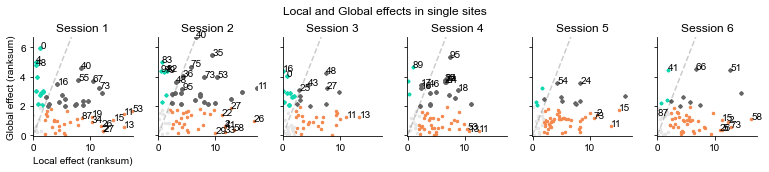

In [16]:
fig,ax = plt.subplots(1,nsess,figsize=(1.8*nsess,2.4),sharex=True,sharey=True)
for sess in range(nsess):
    
    # plot channels with significant local effect only
    channels = np.where((P_loc[sess,:]<=alpha) & (P_glob[sess,:]>alpha))[0]
    for ch in channels:
        ax[sess].plot(abs(U_loc[sess,ch]),abs(U_glob[sess,ch]),'.',color='#f4884d',markersize=5)
        if abs(U_loc[sess,ch])>10:
            ax[sess].annotate(str(ch),xy=(abs(U_loc[sess,ch]),abs(U_glob[sess,ch])))
    
    # plot channels with significant global effect only
    channels = np.where((P_glob[sess,:]<=alpha) & (P_loc[sess,:]>alpha))[0]
    for ch in channels:
        ax[sess].plot(abs(U_loc[sess,(channels)]),abs(U_glob[sess,(channels)]),'.',color='#12d8b2',markersize=5)
        if abs(U_glob[sess,ch])>4:
            ax[sess].annotate(str(ch),xy=(abs(U_loc[sess,ch]),abs(U_glob[sess,ch])))
            
    
    ax[sess].annotate(str(87),xy=(abs(U_loc[sess,87]),abs(U_glob[sess,87])))
    # plot channels with both significant global and local effect
    channels = np.where((P_glob[sess,:]<=alpha) & (P_loc[sess,:]<=alpha))[0]
    for ch in channels:
        ax[sess].plot(abs(U_loc[sess,(channels)]),abs(U_glob[sess,(channels)]),'.',color=[.4,.4,.4],markersize=5)
        if abs(U_glob[sess,ch])>3:
            ax[sess].annotate(str(ch),xy=(abs(U_loc[sess,ch]),abs(U_glob[sess,ch])))
            
    
    # plot channels without any significant effect
    channels = (P_glob[sess,:]>alpha) & (P_loc[sess,:]>alpha)
    ax[sess].plot(abs(U_loc[sess,(channels)]),abs(U_glob[sess,(channels)]),'.',color=[.9,.9,.9],markersize=5)
    
    ax[sess].set_title('Session %s'%(sess+1))
    ax[sess].plot([0,10],[0,10],'k--',alpha=.2) # diagonal
x_maxval = np.nanmax(abs(U_loc))
y_maxval = np.nanmax(abs(U_glob))
ax[0].set_xlim((-.05,x_maxval))
ax[0].set_ylim((-.05,y_maxval))
ax[0].set_ylabel("Global effect (ranksum)")
ax[0].set_xlabel("Local effect (ranksum)")
sb.despine()
plt.suptitle('Local and Global effects in single sites')
plt.tight_layout()
plt.savefig(os.path.join(out_path,'plots','U_Local+Global_%s.pdf'%(animal_id)))
plt.subplots_adjust(top=.8)
plt.show()

Plot single channels

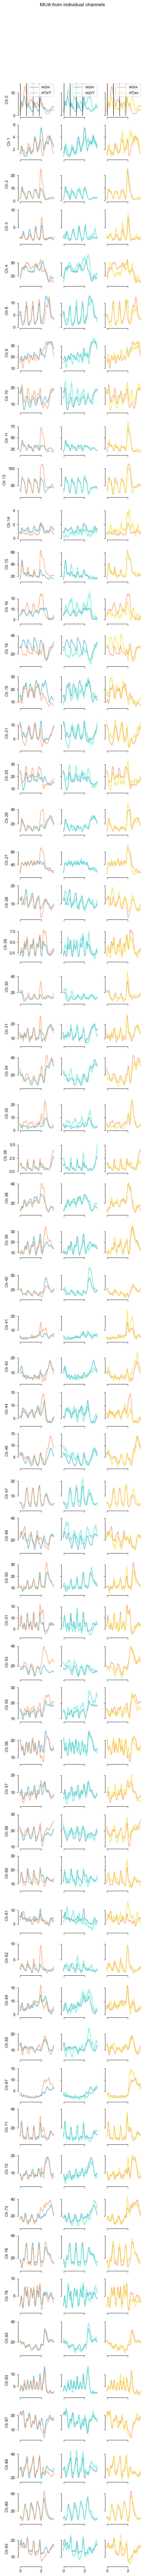

In [18]:
# plot example channel for local effect and global effect 
sess = 0

p_sig = np.where((P_loc[sess,:]<.05) | (P_glob[sess,:]<0.05))[0]
nsites = len(p_sig)

fig,ax = plt.subplots(nsites,3,figsize=(5,1.5*nsites),sharex=True,sharey='row')
labels = [['xx|xx','xY|xY'],['xx|xx','xx|xY'],['xx|xx','xY|xx']]

loc_colors = ['#229eba','#f4884d'] # xx and xY
glob_colors = ['#229eba','#48e5ca'] # xx|xx and xx|xY
locglob_colors = ['#f4884d','#f2dd20'] # xY|xY and xY|xx
for i,ch in enumerate(p_sig):
    
    # LOCAL EFFECT
    for c in range(2):
        ind = (Session==sess) & (Local==c) & (Global==0) & (Include==1)
        av = np.mean(MUA_smooth[ind,ch,:],0)
        sem = np.std(MUA_smooth[ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=loc_colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=loc_colors[c])
    
    # plot global effect
    for c in range(2):
        ind = (Session==sess) & (Local==0) & (Global==c) & (Include==1)
        av = np.mean(MUA_smooth[ind,ch,:],0)
        sem = np.std(MUA_smooth[ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=glob_colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[1][c],color=glob_colors[c])
    
    # plot global+local effect
    for c in range(2):
        ind = (Session==sess) & (Local==1) & (Global==c) & (Include==1)
        av = np.mean(MUA_smooth[ind,ch,:],0)
        sem = np.std(MUA_smooth[ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,2].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=locglob_colors[c])
        ax[i,2].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[2][c],color=locglob_colors[c])
        
    ax[i,0].set_ylabel('Ch %s'%ch)
ymin,ymax = ax[0,0].get_ylim()
for i in range(3):
    ax[0,i].legend()
    for j in range(4):
        ax[0,i].plot([j*soa,j*soa],[ymin,ymax],'k',linewidth=1)
sb.despine(trim=True)
fig.suptitle('MUA from individual channels')
plt.tight_layout()
plt.subplots_adjust(top=.95)
plt.savefig(os.path.join(out_path,'plots','PSTH_examples_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()

summary statistic showing proportion of channels modulated by local, global or both

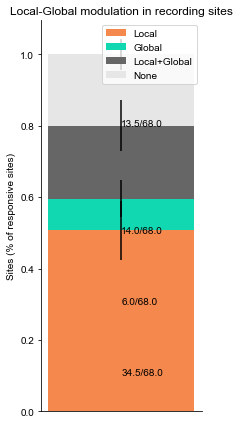

In [20]:
# make summary statistic showing proportion of channels modulated stimulus
# then by local, global or both

# sequence modulation
nch = 96

width = 0.35       # the width of the bars: can also be len(x) sequence

seqSites = [sum(P_seq[sess,:]<=alpha) for sess in range(nsess)]# sites modulated by sequence vs. fixation

# LOCAL AND GLOBAL
locSites = [sum((P_loc[sess,:]<=alpha) & (P_glob[sess,:]>alpha)) for sess in range(nsess)] 
globSites = [sum((P_glob[sess,:]<=alpha) & (P_loc[sess,:]>alpha)) for sess in range(nsess)] 
locglobSites = [sum((P_glob[sess,:]<=alpha) & (P_loc[sess,:]<=alpha)) for sess in range(nsess)] 
noSites = [sum((P_glob[sess,:]>alpha) & (P_loc[sess,:]>alpha)) for sess in range(nsess)] 

locMean = np.mean(np.array(locSites)/np.array(seqSites))
globMean = np.mean(np.array(globSites)/np.array(seqSites))
locglobMean = np.mean(np.array(locglobSites)/np.array(seqSites))
noMean = np.mean(np.array(noSites)/np.array(seqSites))
locSD = np.std(np.array(locSites)/np.array(seqSites))
globSD = np.std(np.array(globSites)/np.array(seqSites))
locglobSD = np.std(np.array(locglobSites)/np.array(seqSites))
noSD = np.std(np.array(noSites)/np.array(seqSites))

plt.figure(figsize=(3,6))
p1 = plt.bar(1, locMean, width, yerr=locSD,color='#f4884d')
p2 = plt.bar(1, globMean, width,
             bottom=locMean, yerr=globSD,color='#12d8b2')
p3 = plt.bar(1, locglobMean, width,
             bottom=locMean+globMean, yerr=locglobSD,color=[.4,.4,.4])
p4 = plt.bar(1, noMean, width,
             bottom=locMean+globMean+locglobMean, yerr=noSD,color=[.9,.9,.9])
plt.annotate(str(np.round(np.mean(locSites),2))+'/'+str(np.round(np.mean(seqSites))),xy=(1,.1))
plt.annotate(str(np.round(np.mean(globSites),2))+'/'+str(np.round(np.mean(seqSites))),xy=(1,.3))
plt.annotate(str(np.round(np.mean(locglobSites),2))+'/'+str(np.round(np.mean(seqSites))),xy=(1,.5))
plt.annotate(str(np.round(np.mean(noSites),2))+'/'+str(np.round(np.mean(seqSites))),xy=(1,.8))
plt.ylabel('Sites (% of responsive sites)')
plt.title('Local-Global modulation in recording sites')
plt.xticks(())
##plt.yticks(np.arange(0, 81, 10))
sb.despine()
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Local', 'Global','Local+Global','None'))
plt.tight_layout()
plt.savefig(os.path.join(out_path,'plots','ModulationRatio_LocGlob_%s.pdf'%(animal_id)))
plt.show()
